### Кейс 4. Классификация с использованием набора данных об академических успехах.
*Состав:*
- Музафаров Карим (PM)
- Цуркан Владислав (ML)
- Зенченко Илья (DA)
- Лямцев Иван (ML)
- Скиф Даниель (DA / ML)
- Богдан (DA)


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv("../data/train.csv", index_col='id')
test = pd.read_csv("../data/test.csv", index_col='id')
train

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,1,1,3,9500,1,1,131.0,1,19,3,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,1,1,2,9500,1,1,132.0,1,19,37,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,1,17,1,9254,1,1,121.0,1,19,1,...,0,6,8,5,10.600000,0,13.9,-0.3,0.79,Graduate
76514,1,1,6,9254,1,1,125.0,1,1,38,...,0,6,9,6,13.875000,0,9.4,-0.8,-3.12,Graduate
76515,5,17,1,9085,1,1,138.0,1,37,37,...,0,5,8,5,11.400000,1,9.4,-0.8,-3.12,Enrolled


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76518 entries, 0 to 76517
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  76518 non-null  int64  
 1   Application mode                                76518 non-null  int64  
 2   Application order                               76518 non-null  int64  
 3   Course                                          76518 non-null  int64  
 4   Daytime/evening attendance                      76518 non-null  int64  
 5   Previous qualification                          76518 non-null  int64  
 6   Previous qualification (grade)                  76518 non-null  float64
 7   Nacionality                                     76518 non-null  int64  
 8   Mother's qualification                          76518 non-null  int64  
 9   Father's qualification                      

In [5]:
# Пропуски
train.isna().sum()

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

In [6]:
# Дубликаты
train.duplicated().sum()

np.int64(0)

In [7]:
train.describe()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,...,76518.00000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000
mean,1.111934,16.054419,1.644410,9001.286377,0.915314,3.658760,132.378766,1.226600,19.837633,23.425076,...,0.05796,0.137053,5.933414,7.234468,4.007201,9.626085,0.062443,11.520340,1.228218,-0.080921
std,0.441669,16.682337,1.229645,1803.438531,0.278416,8.623774,10.995328,3.392183,15.399456,14.921164,...,0.40849,0.933830,1.627182,3.503040,2.772956,5.546035,0.462107,2.653375,1.398816,2.251382
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9119.000000,1.000000,1.000000,125.000000,1.000000,1.000000,4.000000,...,0.00000,0.000000,5.000000,6.000000,1.000000,10.000000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9254.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.00000,0.000000,6.000000,7.000000,5.000000,12.142857,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9670.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.00000,0.000000,6.000000,9.000000,6.000000,13.244048,0.000000,12.700000,2.600000,1.790000
max,6.000000,53.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,12.00000,19.000000,23.000000,33.000000,20.000000,18.000000,12.000000,16.200000,3.700000,3.510000


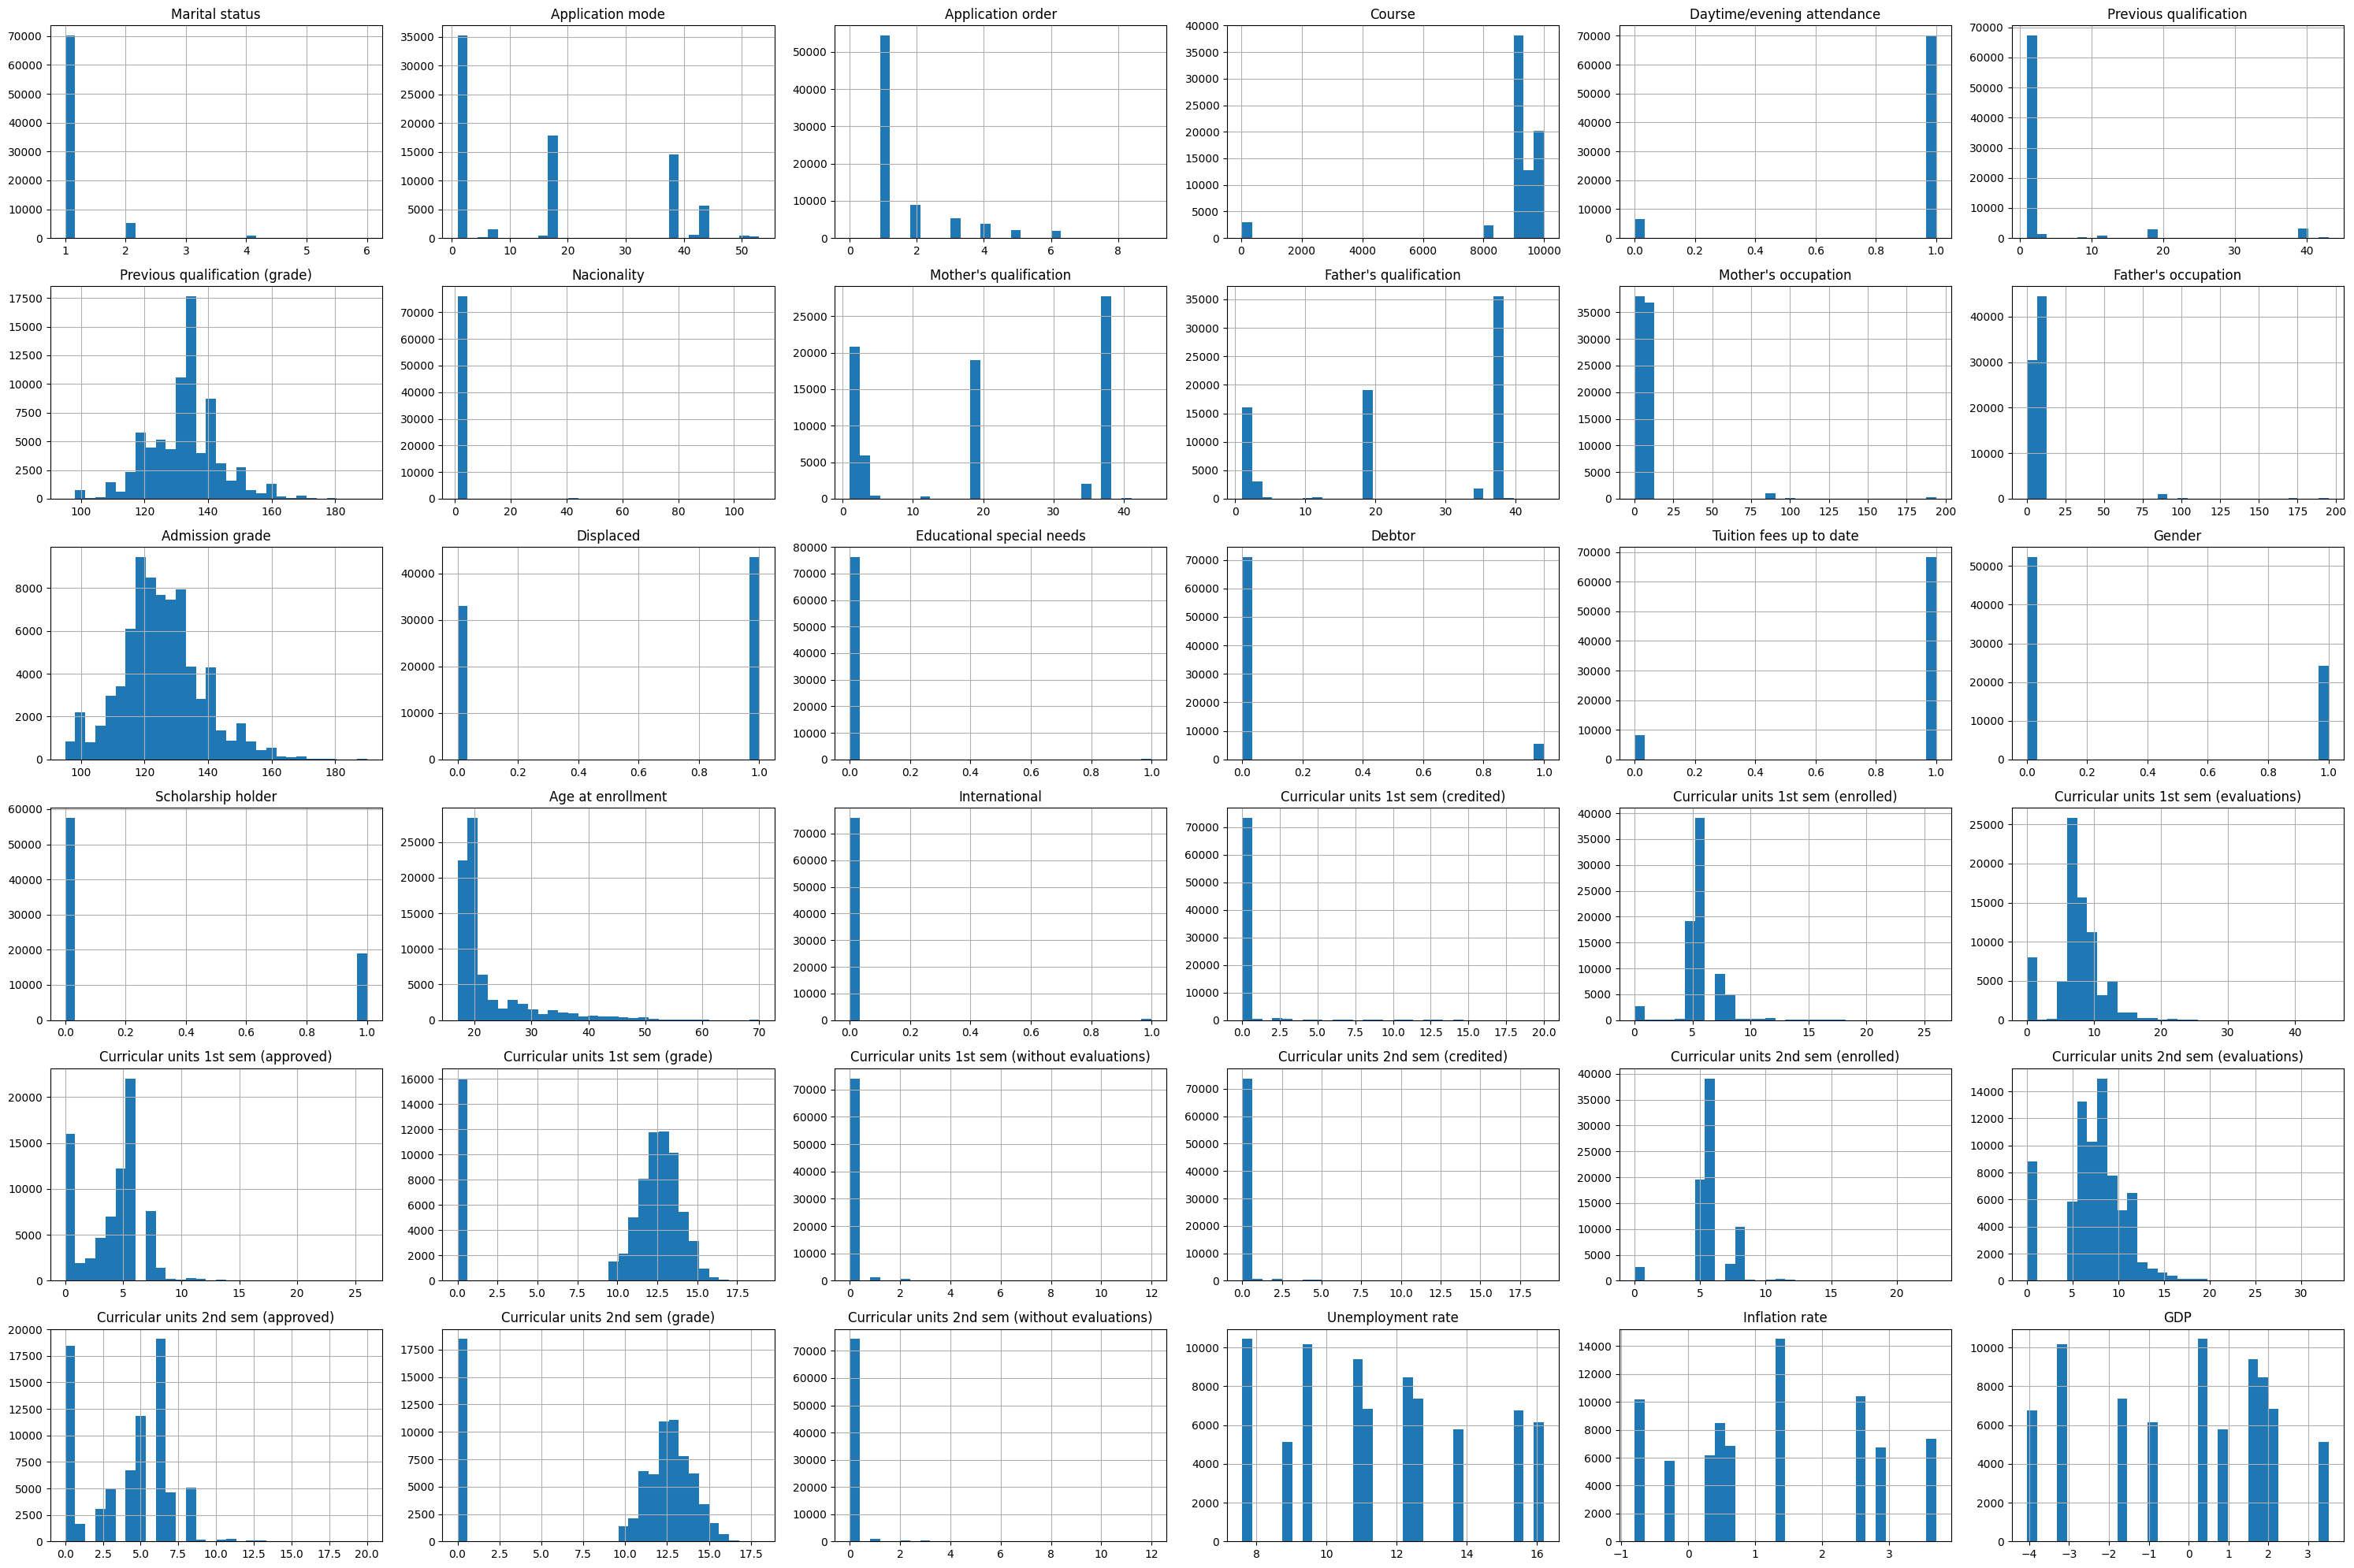

In [8]:
train.hist(figsize=(30, 20), bins=30)
plt.tight_layout()
plt.show()

In [9]:
for col in train.columns:
    print(f'{col} уникальных значений: {train[col].nunique()}')

Marital status уникальных значений: 6
Application mode уникальных значений: 22
Application order уникальных значений: 8
Course уникальных значений: 19
Daytime/evening attendance уникальных значений: 2
Previous qualification уникальных значений: 21
Previous qualification (grade) уникальных значений: 110
Nacionality уникальных значений: 18
Mother's qualification уникальных значений: 35
Father's qualification уникальных значений: 39
Mother's occupation уникальных значений: 40
Father's occupation уникальных значений: 56
Admission grade уникальных значений: 668
Displaced уникальных значений: 2
Educational special needs уникальных значений: 2
Debtor уникальных значений: 2
Tuition fees up to date уникальных значений: 2
Gender уникальных значений: 2
Scholarship holder уникальных значений: 2
Age at enrollment уникальных значений: 46
International уникальных значений: 2
Curricular units 1st sem (credited) уникальных значений: 21
Curricular units 1st sem (enrolled) уникальных значений: 24
Curricu

- Marital status - Семейное положение студента
- Gender - Пол студента
- Age at enrollment - Возраст при поступлении
- Nacionality - Национальность/гражданство
- International - Является ли иностранным студентом
- Previous qualification - Предыдущее образование
- Previous qualification (grade) - Оценка предыдущего образования
- Admission grade - Вступительный балл
- Application mode - Способ подачи заявления
- Application order - Очередь/приоритет заявления
- Course - Выбранная образовательная программа
- Mother's qualification - Образование матери
- Father's qualification - Образование отца
- Mother's occupation - Профессия матери
- Father's occupation - Профессия отца
- Displaced - Является ли вынужденным переселенцем
- Educational special needs - Наличие особых образовательных потребностей
- Debtor - Имеет ли задолженности по оплате
- Tuition fees up to date - Актуальность оплаты обучения(???)
- Scholarship holder - Является ли стипендиатом
- Curricular units 1st sem (credited) - Зачтенные учебные единицы
- Curricular units 1st sem (enrolled) - Зачисленные учебные единицы
- Curricular units 1st sem (evaluations) - Оцененные учебные единицы
- Curricular units 1st sem (approved) - Успешно пройденные учебные единицы
- Curricular units 1st sem (grade) - Средняя оценка за семестр
- Curricular units 1st sem (without evaluations) - Без оценок
- Unemployment rate - Уровень безработицы
- Inflation rate - Уровень инфляции
- GDP - Валовой внутренний продукт

Text(0.5, 1.0, 'Распределение целевых классов')

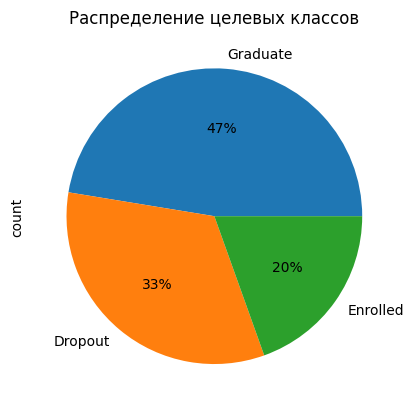

In [ ]:
train["Target"].value_counts().plot.pie(autopct="%.0f%%")
plt.title("Распределение целевых классов")

- Graduate - Успешно окончил обучение
- Dropout - не завершил обучение
- Enrolled - в процессе обучения
### *Промежуточные выводы:* Наблюдается дисбаланс классов

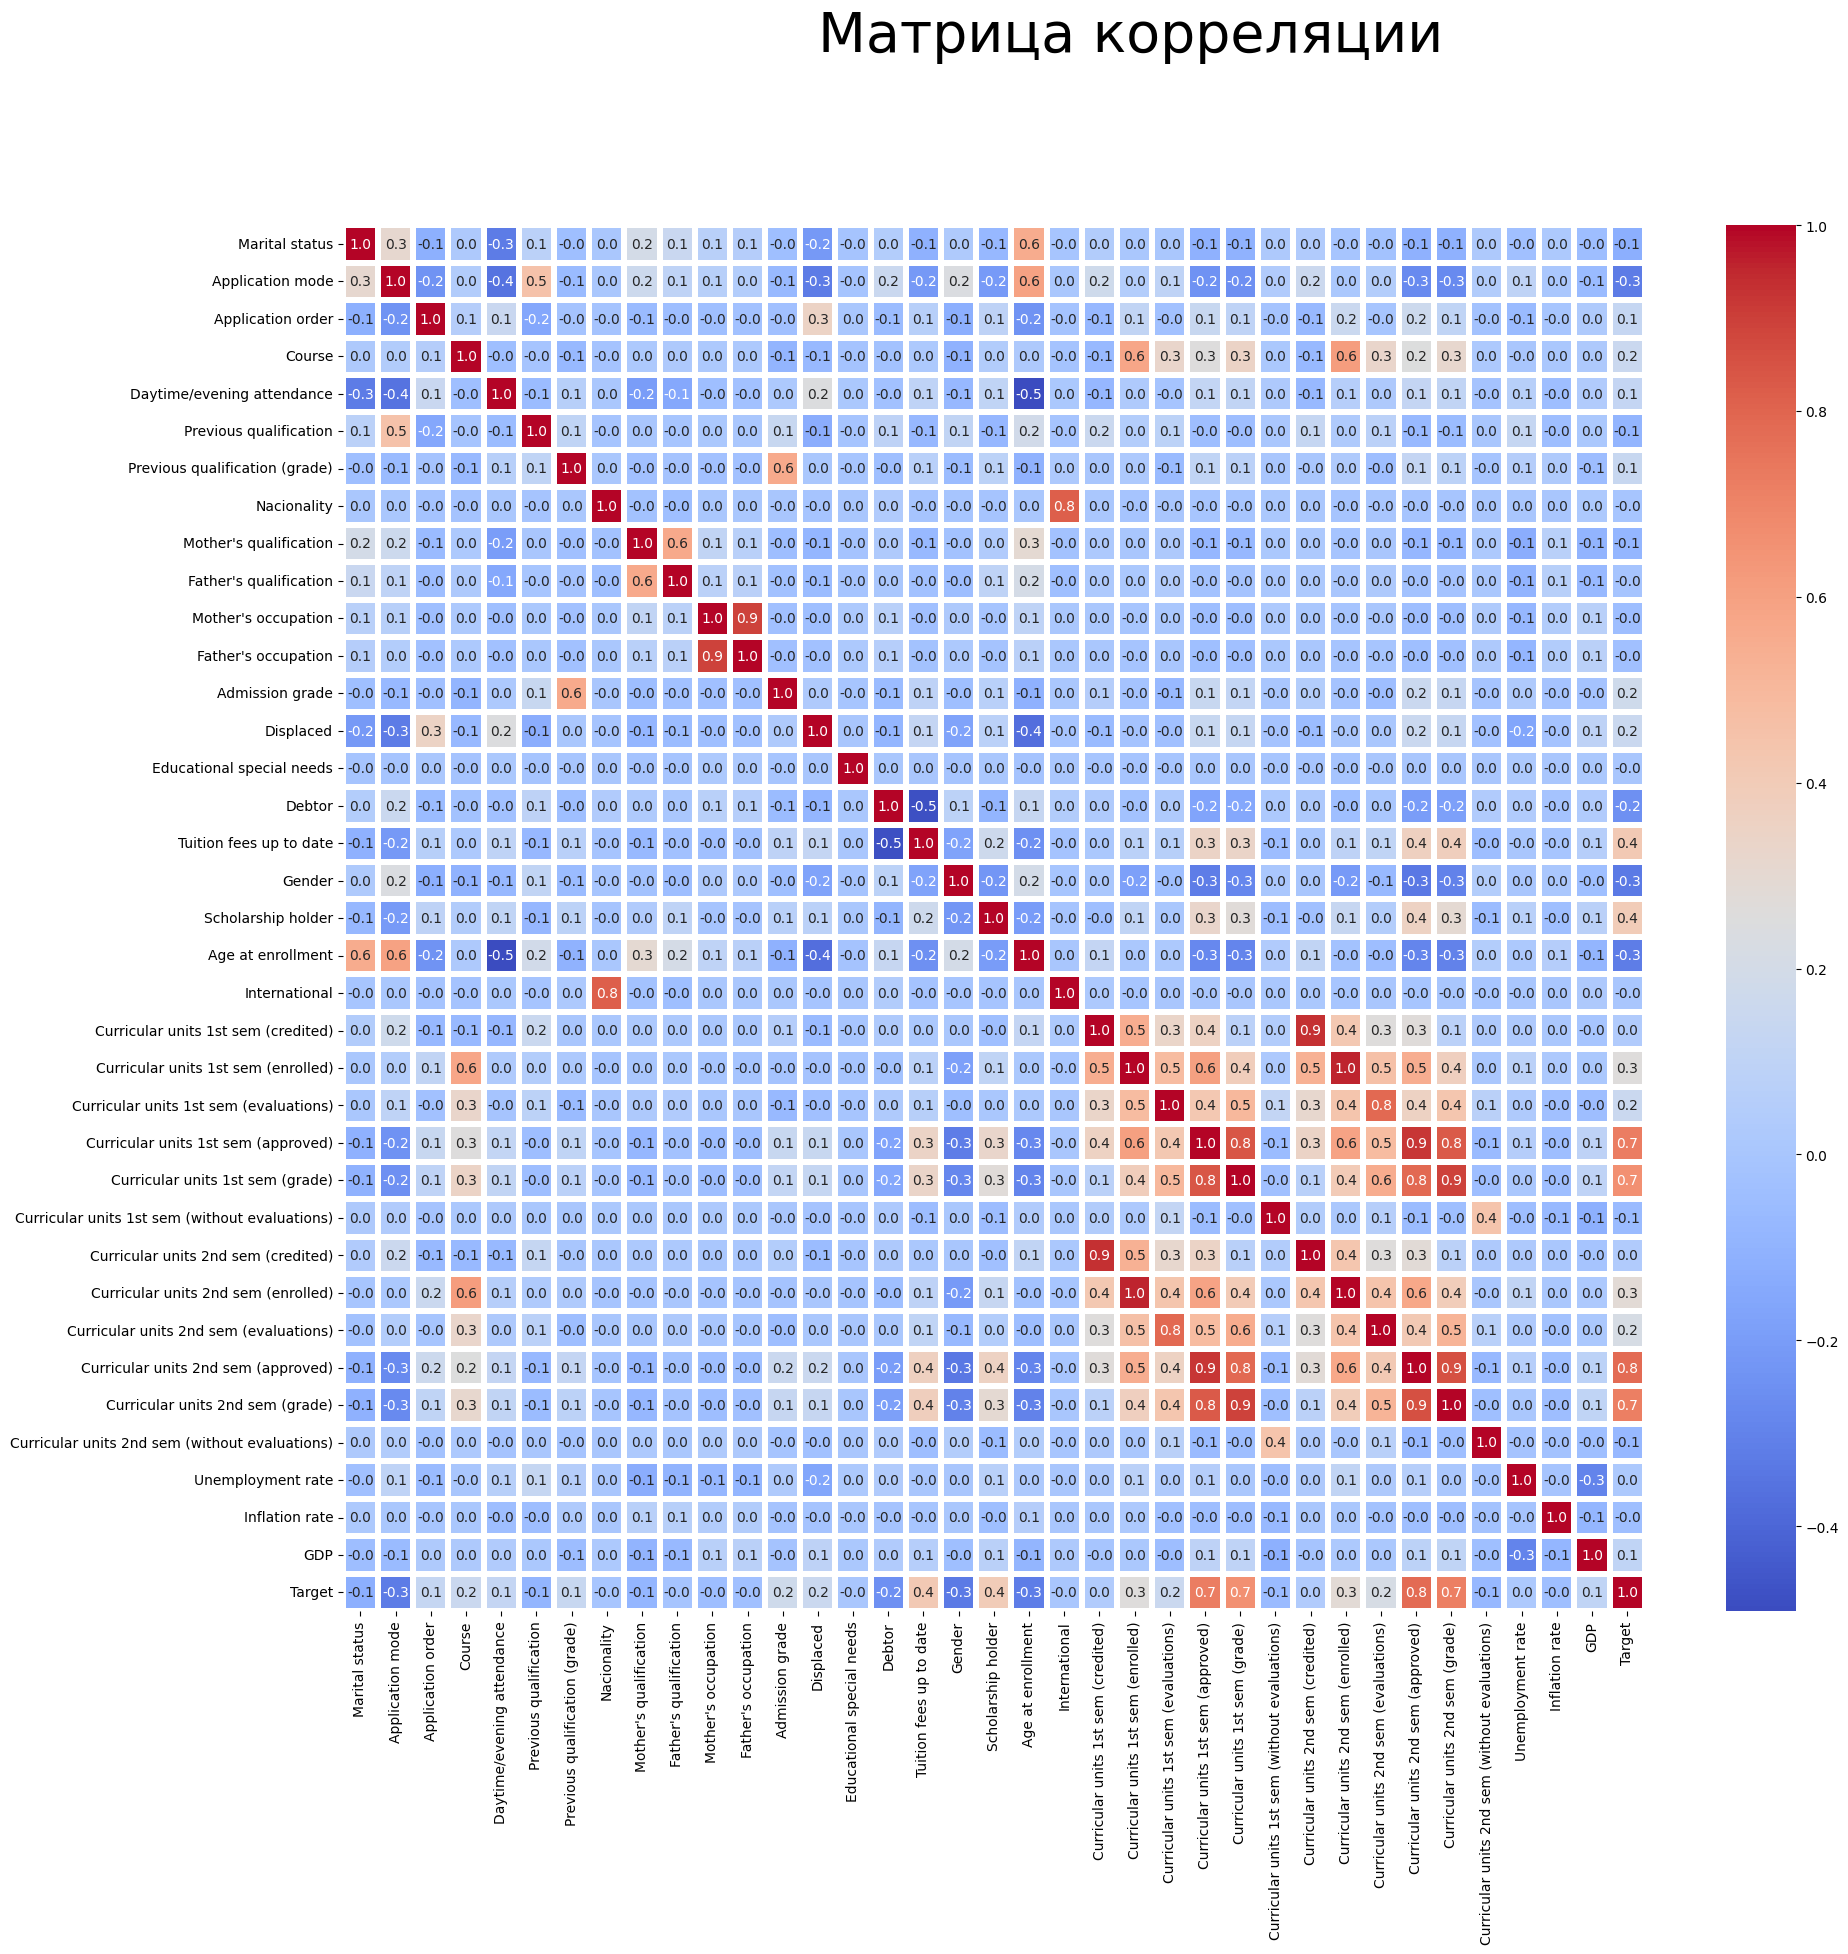

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train['Target'] = label_encoder.fit_transform(train['Target'])


plt.figure(figsize=(21, 18))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', fmt='.1f', linewidths=3)
plt.suptitle('Матрица корреляции', fontsize=40, y=1)
plt.show()

In [16]:
import phik
from phik.report import plot_correlation_matrix

interval columns not set, guessing: ['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation r

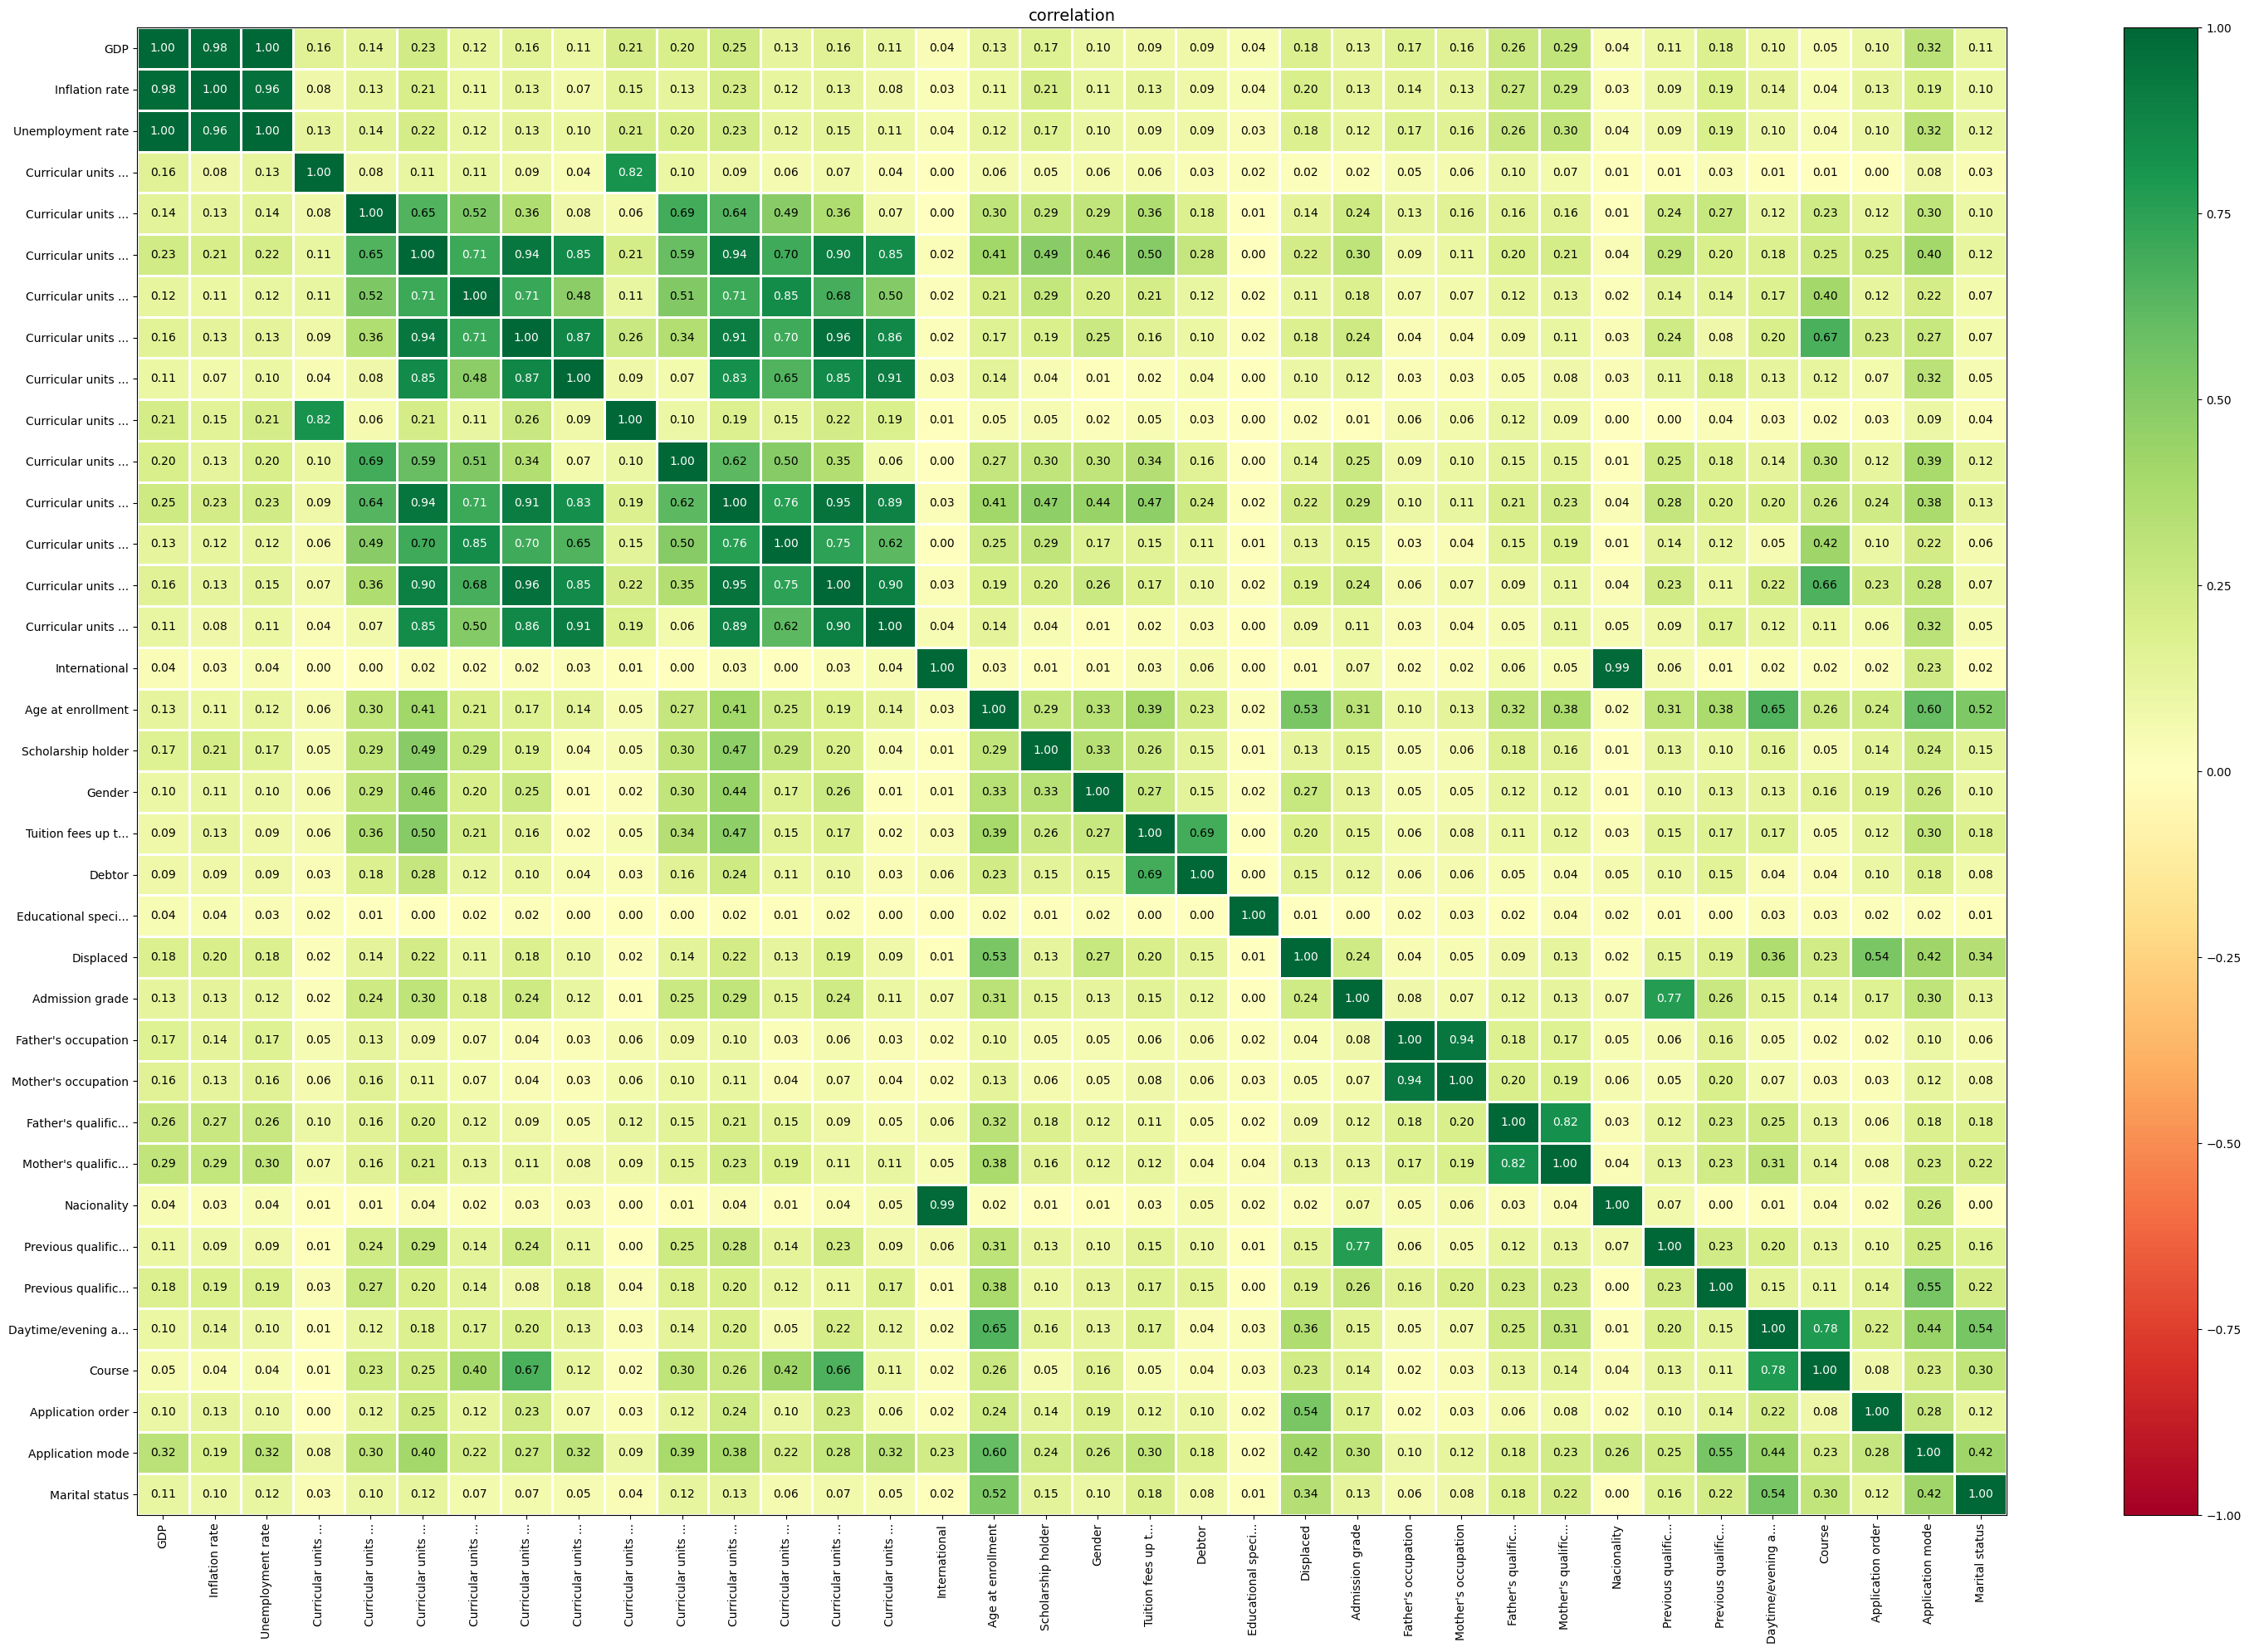

In [22]:
corr_matrix = test.phik_matrix()
plot_correlation_matrix(corr_matrix.values, x_labels=corr_matrix.columns, y_labels=corr_matrix.index, figsize=(30,20))

# Выводы:
- Между nacionality(национальность) и international(является ли иностранным студентом) сильная корреляция. Можно дропнуть nacionality и оставить только признак international.
- Между Unemployment rate(Уровень безработицы), Inflation rate(Уровень инфляции), GDP(Валовой внутренний продукт) сильная корреляция. Можно оставить один признак из них(unemployment rate больше всего коррелирует с target)
- Curricular units 1st sem(*) - эти признаки мультиколлениарны. Можно добавить признак, который будет расчитываться на основе этих признаков.